In [ ]:
!pip install pandas 
!pip install numpy 
!pip install scikit-learn 
!pip install matplotlib 
!pip install seaborn

In [4]:
from src.utils import *

import pandas as pd
import numpy as np

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report

import warnings

In [9]:
## 경고 무시
warnings.filterwarnings('ignore')
## train, test 데이터 불러오기
seed = 0
origin_train = pd.read_csv('../data/train.csv', encoding='cp949').dropna()
origin_test = pd.read_csv('../data/test.csv', encoding='cp949')

# 타겟 변수와 입력 변수 분리
origin_train['Churn'] = np.where(origin_train['Churn'] == 'Yes', 1, 0)
columns = ['CustomerCareCalls', 'MonthsInService', 'DroppedCalls', 'OverageMinutes']
X_train = origin_train.filter(items=columns)
y_train = origin_train['Churn']
objects = []
for idx in range(len(X_train.columns)):
    if X_train.dtypes[idx] == object:
        objects.append(X_train.columns[idx])
X_train, _ = convert_category_into_integer(X_train, objects)

# 데이터 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# t-SNE 적용 (2차원으로 축소)
tsne = TSNE(n_components=2, random_state=seed)
X_train = tsne.fit_transform(X_train)

# t-SNE 결과 시각화 (이탈 여부에 따른 시각화)
plt.figure(figsize=(8, 6))
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], label='No Churn', alpha=0.5)
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], label='Yes Churn', alpha=0.5, color='red')
plt.title('t-SNE Visualization of Churn Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

# 학습 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.4, random_state=seed)

# Random Forest 분류기 모델 훈련
rf_model = RandomForestClassifier(random_state=seed)
rf_model.fit(X_train, y_train)

# 예측 및 평가
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

Explained Variance Ratio: [0.98101543 0.00962033]


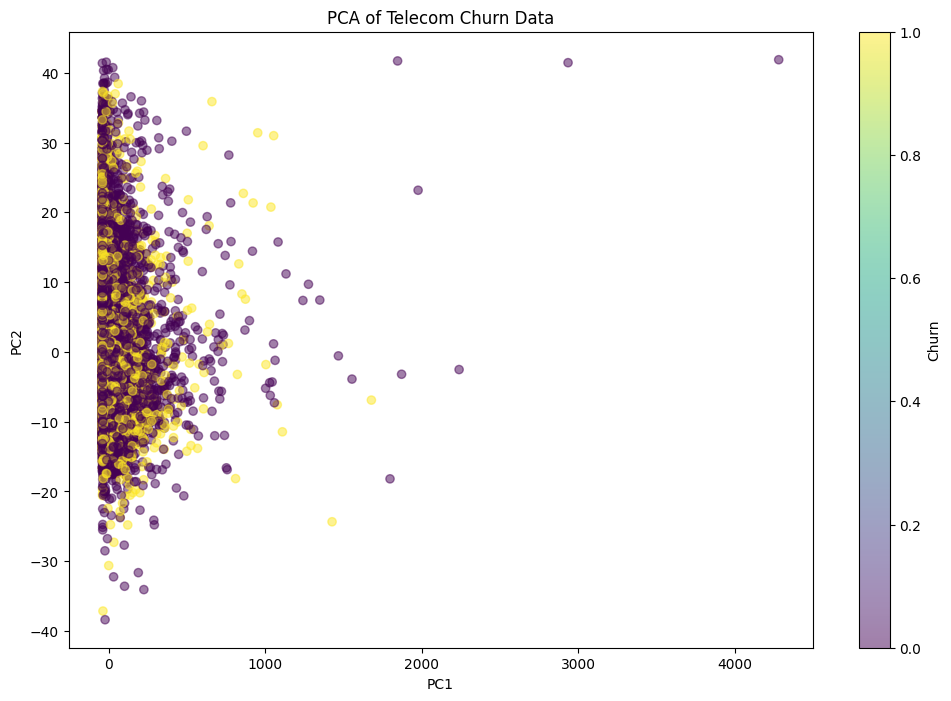

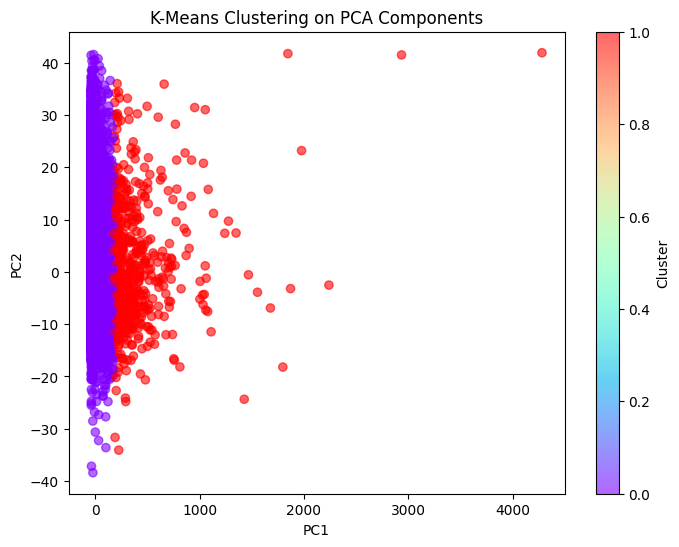

In [5]:
origin_train = pd.read_csv('../data/train.csv', encoding='cp949').dropna()
origin_test = pd.read_csv('../data/test.csv', encoding='cp949')

# origin_train = origin_train.query("MonthlyRevenue < 100")
# origin_train = origin_train.query("MonthlyMinutes < 1200")
# # origin_train = origin_train.query("TotalRecurringCharge < 80")
# # origin_train = origin_train.query("DirectorAssistedCalls < 5")
# origin_train = origin_train.query("OverageMinutes < 20")
columns = ['Churn', 'CustomerCareCalls', 'MonthsInService', 'DroppedCalls', 'OverageMinutes']
train =  origin_train.filter(items=columns)
test = origin_test.filter(items=columns)

# ## 범주형 변수 인코딩하기
train.loc[:, 'Churn'] = LabelEncoder().fit_transform(train.Churn)

## 데이터 종류가 object인 칼럼을 카테고리화 하기
# train = astype_to_category(train)
# test = astype_to_category(test)

## 타겟 변수 정의
target = 'Churn'

## train 데이터 분할하기
seed = 0
train, valid = train_test_split(train, test_size=0.4, random_state=seed)
# print(len(train), len(valid), len(test))
## 특성 스케일링
# compare_columns = train.columns.difference(objects)
# standard_scaler = StandardScaler()
# train.loc[:, compare_columns] = standard_scaler.fit_transform(train.loc[:, compare_columns])
# valid.loc[:, compare_columns] = standard_scaler.transform(valid.loc[:, compare_columns])
# test.loc[:, compare_columns] = standard_scaler.transform(test.loc[:, compare_columns])

scaler = StandardScaler()
scaled_train = scaler.fit_transform(train)
scaled_train = pd.DataFrame(scaled_train, columns=train.columns)

# PCA 적용 (주성분 개수는 임의로 2개로 설정)
tsne = PCA(n_components=2, random_state=seed)
pca_train = tsne.fit_transform(train.drop(columns=target))
pca_train = pd.DataFrame(data=pca_train, columns=['PC1', 'PC2'])
pca_train[target] = train[target]

pca_train = pca_train.loc[pca_train.Churn.isna() == False]
# display(pd.DataFrame(pca_train))

# 각 주성분이 설명하는 분산 비율 확인
print(f"Explained Variance Ratio: {tsne.explained_variance_ratio_}")

plt.figure(figsize=(12,8))
plt.scatter(pca_train['PC1'], pca_train['PC2'], c=pca_train[target], cmap='viridis', alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Telecom Churn Data')
plt.colorbar(label=target)
plt.show()

# 클러스터 수 설정 (임의로 2개 클러스터)
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=seed)

# 클러스터링 적용
kmeans.fit(pca_train)
labels = kmeans.labels_

# 클러스터링 결과를 PCA 결과에 추가
pca_train['Cluster'] = labels

# 클러스터링 결과 시각화
plt.figure(figsize=(8, 6))
plt.scatter(pca_train['PC1'], pca_train['PC2'], c=pca_train['Cluster'], cmap='rainbow', alpha=0.6)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-Means Clustering on PCA Components')
plt.colorbar(label='Cluster')
plt.show()

# train = pd.DataFrame(train, columns=origin_train.columns)
# df_train.corr()
# 범주형 데이터 제외 시킨 칼럼들
# compare_columns = train.columns.difference(objects)

# logit(target, train, valid, seed, compare_columns)
# decision_tree(target, train, test, seed)
# svc(target, train, valid, seed, sample_size=300)

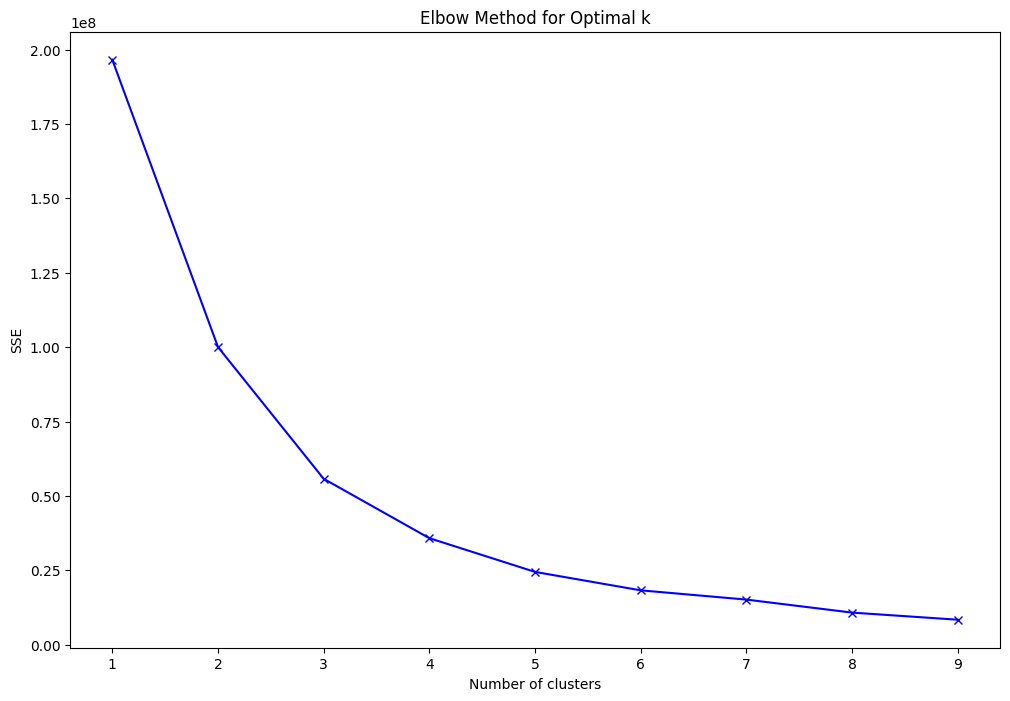

In [6]:
sse = []
k_range = range(1, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=seed)
    kmeans.fit(pca_train)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(12, 8))
plt.plot(k_range, sse, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method for Optimal k')
plt.show()

                 PC1        PC2     Churn
Cluster                                  
0         -35.390391   0.304450  0.299467
1         695.699110   2.795197  0.315789
2          96.421210  -1.230381  0.294526
3        2049.607722  10.779750  0.142857
4         395.212858   0.666563  0.263959
5          18.262849  -0.684909  0.308176
6        1126.158452   4.047191  0.347826
7        4281.363118  41.870947       0.0
8         209.016906  -0.884876  0.330325


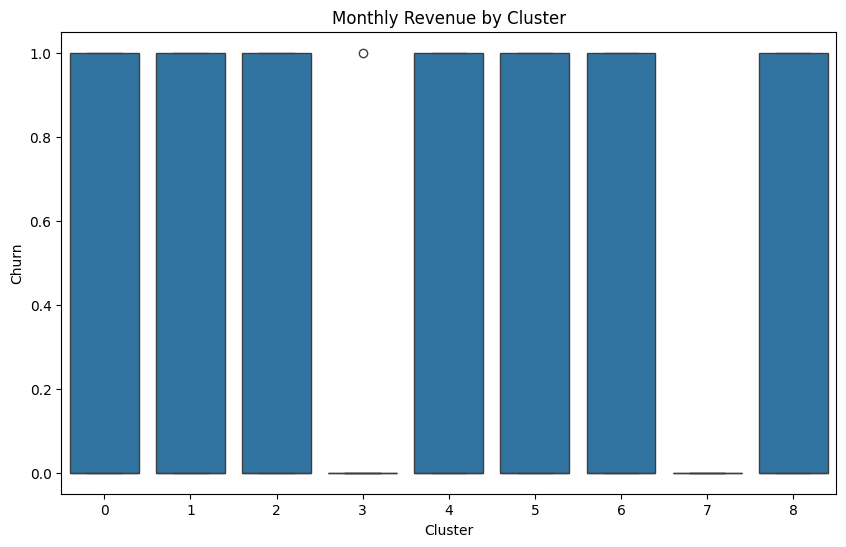

Churn           0         1
Cluster                    
0        0.700533  0.299467
1        0.684211  0.315789
2        0.705474  0.294526
3        0.857143  0.142857
4        0.736041  0.263959
5        0.691824  0.308176
6        0.652174  0.347826
7        1.000000       NaN
8        0.669675  0.330325


In [7]:
# Cluster 정보를 원래 데이터에 추가
pca_train['Cluster'] = kmeans.labels_

# 각 클러스터별로 주요 특성들의 통계 정보 확인
cluster_stats = pca_train.groupby('Cluster').mean()
print(cluster_stats)

# 월 수입에 대한 클러스터별 박스 플롯
plt.figure(figsize=(10,6))
sns.boxplot(data=pca_train, x='Cluster', y='Churn')
plt.title('Monthly Revenue by Cluster')
plt.show()

churn_counts = pca_train.groupby('Cluster')['Churn'].value_counts(normalize=True).unstack()
print(churn_counts)